# Imports

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

import warnings
warnings.filterwarnings("ignore")

In [117]:
LOCAL = True

if LOCAL is True: #work on computer
    path_img = '/mnt/d/Google Drive/Compétition Plant Pathology/data/images/'
    path_train = '/mnt/d/Google Drive/Compétition Plant Pathology/data/train.csv'
    path_test = '/mnt/d/Google Drive/Compétition Plant Pathology/data/test.csv'
    path_submission = '/mnt/d/Google Drive/Compétition Plant Pathology/data/sample_submission.csv'
    path_img_processed = '/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/'
else: #work with google colab
    path_img = '/content/drive/My Drive/Compétition Plant Pathology/data/images/'
    path_train = '/content/drive/My Drive/Compétition Plant Pathology/data/train.csv'
    path_test = '/content/drive/My Drive/Compétition Plant Pathology/data/test.csv'
    path_submission = '/content/drive/My Drive/Compétition Plant Pathology/data/sample_submission.csv'
    path_img_processed = '/content/drive/My Drive/Compétition Plant Pathology/data/images_processed/'

# Data

## Update Dataset

In [118]:
def augment_df(original_df, folder_name):
    '''Updates pd dataframe from original df with folder'''
    
    #on scanne le répertoire
    liste_fichiers = glob.glob(path_img_processed + folder_name + '/*')
    #pour chaque nom de répertoire : on conserve juste les images qui commencent pas train
    liste_fichiers = [x for x in liste_fichiers if 'Train' in x]
    
    liste_fichiers = [x.split(folder_name + '/')[1].split('.jpg')[0] for x in liste_fichiers]
    #on garde le chiffre enre _ et __
    liste_fichiers_orig = [x.split('__')[0] for x in liste_fichiers]
    #on met le tout dans un dataframe
    data_augmented = pd.DataFrame({'image_id' : liste_fichiers_orig,
                                  'augment_image_id' : liste_fichiers})
    #original_df['augment_image_id'] = original_df['image_id']
    data_augmented = pd.merge(original_df, data_augmented, how='outer', on='image_id')
    original_df['augment_image_id'] = original_df['image_id']
    
    return pd.merge(original_df, data_augmented, how='outer').sort_values(by='image_id').reset_index(drop='True')

In [119]:
data_cumul_elastic = augment_df(pd.read_csv(path_train), 
                                folder_name = '6_cumul_elastic')
data_cumul_elastic['label'] = pd.get_dummies(
    data_cumul_elastic[
        ['healthy', 'multiple_diseases', 'rust', 'scab']]).idxmax(axis=1)
data_cumul_non_elastic = augment_df(pd.read_csv(path_train), folder_name = '7_cumul_non_elastic')
data_cumul_non_elastic['label'] = pd.get_dummies(
    data_cumul_non_elastic[
        ['healthy', 'multiple_diseases', 'rust', 'scab']]).idxmax(axis=1)

data_cumul_elastic['filename'] = data_cumul_elastic['augment_image_id'] + '.jpg'
                                                              
data_cumul_elastic['path'] = os.path.join(
    path_img_processed, '6_cumul_elastic+blur/') + data_cumul_elastic['filename']


data_cumul_elastic['basic_path'] = path_img + data_cumul_elastic['path'].apply(lambda x: x.split('/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/6_cumul_elastic+blur/')[1])

In [120]:
data_cumul_elastic.head()['path'].values[0]

'/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/6_cumul_elastic+blur/Train_0.jpg'

(200, 400, 3)


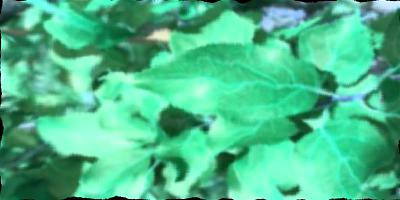

In [121]:
import IPython.display
import PIL.Image

img_test = cv2.imread(data_cumul_elastic.sample(1)['path'].values[0])
print(img_test.shape)
IPython.display.display(PIL.Image.fromarray(img_test))

## Split 

In [122]:

data_original = data_cumul_elastic[data_cumul_elastic['augment_image_id'] == \
                                   data_cumul_elastic['image_id']]
data_non_original = data_cumul_elastic.loc[list(
    data_cumul_elastic.index.difference(data_original.index))]


In [123]:
from sklearn.model_selection import train_test_split
train_original, validation = train_test_split(data_original, 
                                     train_size = 0.7, 
                                    random_state = 22)

In [124]:
train = pd.concat([train_original,data_non_original])

In [125]:
#compute class_weights
from sklearn.utils.class_weight import compute_class_weight
sw = compute_class_weight(class_weight= 'balanced',
                     classes = np.unique(train['label']),
                     y = train['label'])

sw_dict = {}
for i,label in enumerate(np.unique(train['label'])):
    sw_dict[label] = sw[i]
train['sample_weights'] = train['label'].map(sw_dict)

In [126]:
train.sample(10)

,image_id,healthy,multiple_diseases,rust,scab,augment_image_id,label,filename,path,basic_path,sample_weights
5037,Train_266,1,0,0,0,Train_266__2,healthy,Train_266__2.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.880090
5303,Train_313,0,0,1,0,Train_313__3,rust,Train_313__3.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
2274,Train_1406,0,0,1,0,Train_1406__2,rust,Train_1406__2.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
7544,Train_717,0,0,0,1,Train_717__3,scab,Train_717__3.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
6883,Train_599,0,0,0,1,Train_599__0,scab,Train_599__0.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
3853,Train_1691,1,0,0,0,Train_1691__0,healthy,Train_1691__0.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.880090
8980,Train_977,1,0,0,0,Train_977,healthy,Train_977.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.880090
8541,Train_898,0,0,0,1,Train_898__2,scab,Train_898__2.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
3113,Train_1558,0,1,0,0,Train_1558,multiple_diseases,Train_1558.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,5.094048
6897,Train_600,0,0,0,1,Train_600__1,scab,Train_600__1.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881


In [127]:
validation.sample(10)

,image_id,healthy,multiple_diseases,rust,scab,augment_image_id,label,filename,path,basic_path
8898,Train_961,1,0,0,0,Train_961,healthy,Train_961.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
6315,Train_497,0,0,1,0,Train_497,rust,Train_497.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
8554,Train_9,1,0,0,0,Train_9,healthy,Train_9.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
7258,Train_666,0,0,1,0,Train_666,rust,Train_666.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
2599,Train_1465,0,0,1,0,Train_1465,rust,Train_1465.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
3453,Train_1619,0,0,0,1,Train_1619,scab,Train_1619.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
3225,Train_1579,0,0,1,0,Train_1579,rust,Train_1579.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
785,Train_1139,1,0,0,0,Train_1139,healthy,Train_1139.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
4595,Train_187,0,0,1,0,Train_187,rust,Train_187.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...
6925,Train_606,0,0,1,0,Train_606,rust,Train_606.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...


In [128]:
compar_result = pd.DataFrame()
compar_result = pd.DataFrame(columns = ['source', 'healthy', 'multiple_diseases', 'rust', 'scab'])
for source, df in zip(['dataset', 'train', 'validate'], 
                      [data_cumul_elastic, 
                      train, 
                      validation]): 
    compar_result = compar_result.append({'source' : source,
                         'healthy' : df['healthy'].mean(),
                         'multiple_diseases' : df['multiple_diseases'].mean(),
                         'rust' : df['rust'].mean(),
                         'scab' : df['scab'].mean(),
                         }, ignore_index=True)

In [129]:
compar_result

,source,healthy,multiple_diseases,rust,scab
0,dataset,0.283361,0.049973,0.341571,0.325096
1,train,0.284062,0.049077,0.342136,0.324725
2,validate,0.272395,0.063985,0.332724,0.330896


## Generators

In [130]:
train['path'].head().values[0]

'/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/6_cumul_elastic+blur/Train_869.jpg'

In [131]:
train['basic_path'] = path_img + train['path'].apply(lambda x: x.split('/mnt/d/Google Drive/Compétition Plant Pathology/data/images_processed/6_cumul_elastic+blur/')[1])

In [132]:
train[train['image_id'] ==  train['augment_image_id']]

,image_id,healthy,multiple_diseases,rust,scab,augment_image_id,label,filename,path,basic_path,sample_weights
8380,Train_869,0,0,0,1,Train_869,scab,Train_869.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
9022,Train_984,0,0,0,1,Train_984,scab,Train_984.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
2892,Train_1518,0,0,0,1,Train_1518,scab,Train_1518.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
615,Train_1108,0,0,1,0,Train_1108,rust,Train_1108.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
3339,Train_1599,0,0,1,0,Train_1599,rust,Train_1599.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
...,...,...,...,...,...,...,...,...,...,...,...
1783,Train_1318,0,0,1,0,Train_1318,rust,Train_1318.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
4804,Train_223,0,0,1,0,Train_223,rust,Train_223.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
4061,Train_1729,0,0,1,0,Train_1729,rust,Train_1729.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
660,Train_1116,0,0,1,0,Train_1116,rust,Train_1116.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704


In [133]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '6_cumul_elastic/',),
                                             x_col = 'path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32)

train_generator_base = datagen.flow_from_dataframe(dataframe =
                                                   train[train['image_id'] == 
                                                         train['augment_image_id']],
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '6_cumul_elastic/',),
                                             x_col = 'basic_path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32)

train_generator_base_augmented = datagen.flow_from_dataframe(dataframe =
                                                   train[train['image_id'] == 
                                                         train['augment_image_id']],
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '6_cumul_elastic/',),
                                             x_col = 'basic_path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=10,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             zoom_range=.1,
                                             rescale=1/255,
                                             shear_range=0.1,
                                             brightness_range=[0.5, 1.5])

validation_generator_base = datagen.flow_from_dataframe(dataframe = validation,
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '3_gaussian_blur/',),
                                             x_col = 'basic_path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             batch_size=32,
                                             target_size=(400,200),
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=10,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             zoom_range=.1,
                                             rescale=1/255,
                                             shear_range=0.1,
                                             brightness_range=[0.5, 1.5])

validation_generator_base_augment = datagen.flow_from_dataframe(dataframe = validation,
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '3_gaussian_blur/',),
                                             x_col = 'basic_path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32)




validation_generator = datagen.flow_from_dataframe(dataframe = validation,
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '3_gaussian_blur/',),
                                             x_col = 'path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32)

Found 8558 validated image filenames belonging to 4 classes.
Found 1274 validated image filenames belonging to 4 classes.
Found 1274 validated image filenames belonging to 4 classes.
Found 547 validated image filenames belonging to 4 classes.
Found 547 validated image filenames belonging to 4 classes.
Found 547 validated image filenames belonging to 4 classes.


In [134]:
train_generator_100 = datagen.flow_from_dataframe(dataframe = train.sample(100,random_state=22),
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '6_cumul_elastic/',),
                                             x_col = 'path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32,
                                            shuffle=False)

Found 100 validated image filenames belonging to 4 classes.


In [135]:
sw_indices = {}
for i,value in enumerate(sw_dict.values()):
    sw_indices[i] = value

In [136]:
sw_indices

{0: 0.8800904977375565,
 1: 5.094047619047619,
 2: 0.7307035519125683,
 3: 0.7698812522490104}

In [137]:
train

,image_id,healthy,multiple_diseases,rust,scab,augment_image_id,label,filename,path,basic_path,sample_weights
8380,Train_869,0,0,0,1,Train_869,scab,Train_869.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
9022,Train_984,0,0,0,1,Train_984,scab,Train_984.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
2892,Train_1518,0,0,0,1,Train_1518,scab,Train_1518.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
615,Train_1108,0,0,1,0,Train_1108,rust,Train_1108.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
3339,Train_1599,0,0,1,0,Train_1599,rust,Train_1599.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
...,...,...,...,...,...,...,...,...,...,...,...
9099,Train_998,0,0,0,1,Train_998__3,scab,Train_998__3.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.769881
9101,Train_999,0,0,1,0,Train_999__1,rust,Train_999__1.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
9102,Train_999,0,0,1,0,Train_999__2,rust,Train_999__2.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704
9103,Train_999,0,0,1,0,Train_999__3,rust,Train_999__3.jpg,/mnt/d/Google Drive/Compétition Plant Patholog...,/mnt/d/Google Drive/Compétition Plant Patholog...,0.730704


In [138]:
train_generator_1000 = datagen.flow_from_dataframe(
    dataframe = train.sample(1000, random_state=42),
    #directory = os.path.join(path_img_processed,'6_cumul_elastic/',),
    x_col = 'path',
    y_col = 'label',
    class_mode="categorical",
    target_size=(400,200),
    batch_size=32)

Found 1000 validated image filenames belonging to 4 classes.


In [139]:
validation_generator_1000 = datagen.flow_from_dataframe(dataframe = validation.sample(250,random_state=42),
                                             #directory = os.path.join(
                                             #    path_img_processed, 
                                             #    '3_gaussian_blur/',),
                                             x_col = 'path',
                                             y_col = 'label',
                                             class_mode="categorical",
                                             target_size=(400,200),
                                             batch_size=32)

Found 250 validated image filenames belonging to 4 classes.


# Models

In [140]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

## Functions

In [141]:
def plot_validate(model, loss_acc):
    '''
    Plot model accuracy or loss for both train and test validation per epoch
    model : fitted model
    loss_acc : input 'loss' or 'acc' to plot respective graph
    '''
    history = model.history.history

    if loss_acc == 'loss':
        axis_title = 'loss'
        title = 'Loss'
        epoch = len(history['loss'])
    elif loss_acc == 'acc':
        axis_title = 'categorical_accuracy'
        title = 'Accuracy'
        epoch = len(history['loss'])

    plt.figure(figsize=(15,4))
    plt.plot(history[axis_title])
    plt.plot(history['val_' + axis_title])
    plt.title('Model ' + title)
    plt.ylabel(title)
    plt.xlabel('Epoch')

    plt.grid(b=True, which='major')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', alpha=0.2)

    plt.legend(['Train', 'Test'])
    plt.show()

## Parameters

In [142]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint best model (least val_loss)
best_w = ModelCheckpoint('plant_best.h5',
                                monitor='loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

#checkpoint last model
last_w = ModelCheckpoint('plant_last.h5',
                               monitor='loss',
                                verbose=0,
                                save_best_only=False,
                              mode='auto',
                                period=1)

#Reduce learning rate when metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.2,
                              patience=2, 
                              min_lr=0.000001, 
                              verbose=1,
                              cooldown=1)

callbacks = [best_w, last_w, reduce_lr]

In [143]:
STEP_SIZE_TRAIN =train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =validation_generator.n//validation_generator.batch_size

## Baseline : EfficientNetB0 basic image

In [102]:
import efficientnet.tfkeras as efn 

model_eff_B0_base =  efn.EfficientNetB0(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_eff_B0_base.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_eff_B0_base = Model(inputs= model_eff_B0_base.input,
                     outputs= top_model(model_eff_B0_base.output))

del top_model

for layer in model_eff_B0_base.layers[:-1]:
    layer.trainable=False    

model_eff_B0_base.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_eff_B0_base.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 200, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 200, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 200, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [105]:
TRAINING_BASE = True

In [144]:
if TRAINING_BASE is True:
    model_eff_B0_base.fit_generator(generator = train_generator_base,
                          steps_per_epoch=train_generator_base.n//train_generator_base.batch_size,
                          validation_data=validation_generator_base,
                          validation_steps = validation_generator_base.n//validation_generator_base.batch_size,
                              epochs=20,
                              callbacks=callbacks)
    model_eff_B0_base.save('model_eff_B0_base_2020_05_15.model')
    model_eff_B0_base.save_weights('model_eff_B0_base_2020_05_15.weights')
    
else:
    model_eff_B0_base.load_weights('model_eff_B0_2020_base_05_15.weights')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 17 steps
Epoch 1/20
39/39 [==============================] - 197s 5s/step - loss: 0.0168 - categorical_accuracy: 0.9968 - val_loss: 3.5960 - val_categorical_accuracy: 0.7665
Epoch 2/20
39/39 [==============================] - 189s 5s/step - loss: 0.0502 - categorical_accuracy: 0.9903 - val_loss: 3.5947 - val_categorical_accuracy: 0.7665
Epoch 3/20
39/39 [==============================] - 188s 5s/step - loss: 0.0056 - categorical_accuracy: 0.9968 - val_loss: 3.5970 - val_categorical_accuracy: 0.7665
Epoch 4/20
39/39 [==============================] - 190s 5s/step - loss: 0.0274 - categorical_accuracy: 0.9952 - val_loss: 3.5940 - val_categorical_accuracy: 0.7665
Epoch 5/20
39/39 [==============================] - 188s 5s/step - loss: 0.0280 - categorical_accuracy: 0.9960 - val_loss: 3.5934 - val_categorical_accuracy: 0.7665
Epoch 6/20
39/39 [==============================] - 189s 5s/step - loss: 0.0070 - c

## EfficientNetB0 data augmentation keras

In [108]:
import efficientnet.tfkeras as efn 

model_eff_B0_base_augmented =  efn.EfficientNetB0(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_eff_B0_base_augmented.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_eff_B0_base_augmented = Model(inputs= model_eff_B0_base_augmented.input,
                     outputs= top_model(model_eff_B0_base_augmented.output))

del top_model

for layer in model_eff_B0_base_augmented.layers[:-1]:
    layer.trainable=False    

model_eff_B0_base_augmented.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_eff_B0_base_augmented.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 200, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 200, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 200, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [109]:
TRAINING_BASE_AUGMENTED = True

In [110]:
if TRAINING_BASE_AUGMENTED is True:
    model_eff_B0_base_augmented.fit_generator(generator = train_generator_base_augmented,
                          steps_per_epoch=train_generator_base.n//train_generator_base_augmented.batch_size,
                          validation_data=validation_generator,
                          validation_steps = validation_generator.n//validation_generator.batch_size,
                              epochs=20,
                              callbacks=callbacks)
    model_eff_B0_base_augmented.save('model_eff_B0_base_augmented_2020_05_15.model')
    model_eff_B0_base_augmented.save_weights('model_eff_B0_base_augmented_2020_05_15.weights')
    
else:
    model_eff_B0_base_augmented.load_weights('model_eff_B0_2020_base_augmented_05_15.weights')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 39 steps, validate for 17 steps
Epoch 1/20
39/39 [==============================] - 190s 5s/step - loss: 4.1768 - categorical_accuracy: 0.5950 - val_loss: 6.8474 - val_categorical_accuracy: 0.4118
Epoch 2/20
39/39 [==============================] - 186s 5s/step - loss: 1.2319 - categorical_accuracy: 0.8261 - val_loss: 4.2904 - val_categorical_accuracy: 0.5368
Epoch 3/20
39/39 [==============================] - 190s 5s/step - loss: 0.6747 - categorical_accuracy: 0.8857 - val_loss: 4.8324 - val_categorical_accuracy: 0.4890
Epoch 4/20
39/39 [==============================] - 187s 5s/step - loss: 0.3005 - categorical_accuracy: 0.9412 - val_loss: 6.9791 - val_categorical_accuracy: 0.4301
Epoch 5/20
39/39 [==============================] - 188s 5s/step - loss: 0.0947 - categorical_accuracy: 0.9767 - val_loss: 5.3338 - val_categorical_accuracy: 0.5257
Epoch 6/20
39/39 [==============================] - 191s 5s/step - loss: 0.1629 - c

## EfficientNetB0 data augmentation maison

In [145]:

import efficientnet.tfkeras as efn 

model_eff_B0 =  efn.EfficientNetB0(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_eff_B0.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_eff_B0 = Model(inputs= model_eff_B0.input,
                     outputs= top_model(model_eff_B0.output))

del top_model

for layer in model_eff_B0.layers[:-1]:
    layer.trainable=False    

model_eff_B0.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_eff_B0.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 200, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 200, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 200, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [150]:
TRAINING_BASE_AUG = True

In [155]:
if TRAINING_BASE_AUG is True:
    model_eff_B0.fit_generator(generator = train_generator,
                          steps_per_epoch=train_generator.n//train_generator.batch_size,
                          validation_data=validation_generator,
                          validation_steps = validation_generator.n//validation_generator.batch_size,
                          epochs=20,
                          callbacks=callbacks)
    model_eff_B0.save('model_eff_B0_2020_05_16.model')
    model_eff_B0.save_weights('model_eff_B0_2020_05_16.weights')
    
else:
    model_eff_B0.load_weights('model_eff_B0_2020_05_16_total.weights')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 267 steps, validate for 17 steps
Epoch 1/20
267/267 [==============================] - 1140s 4s/step - loss: 0.0488 - categorical_accuracy: 0.9907 - val_loss: 0.9927 - val_categorical_accuracy: 0.8860
Epoch 2/20
267/267 [==============================] - 1183s 4s/step - loss: 0.0605 - categorical_accuracy: 0.9886 - val_loss: 0.9900 - val_categorical_accuracy: 0.8860
Epoch 3/20
267/267 [==============================] - 1152s 4s/step - loss: 0.0870 - categorical_accuracy: 0.9869 - val_loss: 0.9890 - val_categorical_accuracy: 0.8842
Epoch 4/20
267/267 [==============================] - 1054s 4s/step - loss: 0.0542 - categorical_accuracy: 0.9890 - val_loss: 0.9842 - val_categorical_accuracy: 0.8860
Epoch 5/20
267/267 [==============================] - 1093s 4s/step - loss: 0.0578 - categorical_accuracy: 0.9897 - val_loss: 0.9782 - val_categorical_accuracy: 0.8879
Epoch 6/20
267/267 [==============================] - 950s 4s/step 

In [67]:
predict_100 = model_eff_B0.predict_generator(train_generator_100)

Instructions for updating:
Please use Model.predict, which supports generators.


In [68]:
predict_100.argmax(axis=1)

array([0, 3, 3, 2, 3, 2, 2, 2, 2, 0, 1, 0, 0, 3, 0, 1, 2, 1, 3, 0, 2, 0,
       3, 0, 3, 2, 3, 0, 2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 1, 3, 0, 2,
       3, 0, 3, 3, 2, 2, 3, 0, 2, 2, 2, 2, 3, 3, 2, 3, 0, 3, 2, 2, 3, 2,
       3, 2, 2, 2, 1, 2, 3, 0, 2, 1, 3, 2, 3, 2, 0, 0, 2, 3, 0, 1, 0, 0,
       3, 2, 3, 3, 3, 3, 0, 2, 2, 2, 2, 0])

In [69]:
np.array(train_generator_100.classes)

array([0, 3, 3, 2, 3, 2, 2, 2, 2, 0, 1, 0, 0, 3, 0, 1, 2, 1, 3, 0, 2, 0,
       3, 0, 3, 2, 3, 0, 2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 1, 3, 0, 2,
       3, 0, 3, 3, 2, 2, 3, 0, 2, 2, 2, 2, 3, 3, 2, 3, 0, 3, 2, 2, 3, 2,
       3, 2, 2, 2, 1, 2, 3, 0, 2, 1, 3, 2, 3, 2, 0, 0, 2, 3, 0, 1, 0, 0,
       3, 2, 3, 3, 3, 3, 0, 2, 2, 2, 2, 0])

In [70]:
score = 0
for i, j in zip(train_generator_100.classes, np.argmax(predict_100, axis=1).tolist()):
    if i == j:
        score +=1
        

In [71]:
print(score)

100


## EfficientNetB0 + Sample Weights

In [ ]:
import efficientnet.tfkeras as efn 

model_eff_B0_sw =  efn.EfficientNetB0(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_eff_B0.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_eff_B0 = Model(inputs= model_eff_B0.input,
                     outputs= top_model(model_eff_B0.output))

del top_model

for layer in model_eff_B0.layers[:-1]:
    layer.trainable=False    

model_eff_B0_sw.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_eff_B0_sw.summary()


In [ ]:
?model_eff_B0_sw.compile

In [ ]:
?model_eff_B0_sw.fit

In [ ]:
xsw_indices

In [ ]:
model_eff_B0_sw.fit(x = train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=10,
                    callbacks=callbacks,
                    class_weight = sw_indices,
                   workers=4)
model_eff_B0_sw.save('model_eff_B0_2020_05_13_sw.model')
model_eff_B0_sw.save_weights('model_eff_B0_2020_05_13_sw.weights')

In [ ]:
plot_validate(model_eff_B0_sw, 'acc')

In [ ]:
plot_validate(model_eff_B0_sw, 'loss')

## Efficientnet B7

In [153]:
model_eff_B7 =  efn.EfficientNetB7(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_eff_B7.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_eff_B7 = Model(inputs= model_eff_B7.input,
                     outputs= top_model(model_eff_B7.output))

del top_model

for layer in model_eff_B7.layers[:-1]:
    layer.trainable=False    

model_eff_B7.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_eff_B7.summary()


258441216/258434480 [==============================] - 27s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 100, 200, 64) 1728        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 100, 200, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 100, 200, 64) 0           stem_bn[0][0]                    
________________________

__________________________________________________________________________________________________
block5f_se_excite (Multiply)    (None, 13, 25, 1344) 0           block5f_activation[0][0]         
                                                                 block5f_se_expand[0][0]          
__________________________________________________________________________________________________
block5f_project_conv (Conv2D)   (None, 13, 25, 224)  301056      block5f_se_excite[0][0]          
__________________________________________________________________________________________________
block5f_project_bn (BatchNormal (None, 13, 25, 224)  896         block5f_project_conv[0][0]       
__________________________________________________________________________________________________
block5f_drop (FixedDropout)     (None, 13, 25, 224)  0           block5f_project_bn[0][0]         
__________________________________________________________________________________________________
block5f_ad

In [154]:
model_eff_B7.fit_generator(generator = train_generator,
                      steps_per_epoch=train_generator.n//train_generator.batch_size,
                      validation_data=validation_generator,
                      validation_steps = validation_generator.n//validation_generator.batch_size,
                          epochs=20,
                          callbacks=callbacks)
model_eff_B7.save('model_eff_B7_2020_05_17.model')
model_eff_B7.save_weights('model_eff_B7_2020_05_16.weights')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 267 steps, validate for 17 steps
Epoch 1/20
  8/267 [..............................] - ETA: 2:27:18 - loss: 21.0300 - categorical_accuracy: 0.3304

KeyboardInterrupt: 

## Xception

## Resnet152

## Resnet50 - ne converge pas

In [38]:
from tensorflow.keras.applications import ResNet50
model_res_50 = ResNet50(include_top = False, 
                        weights = 'imagenet', 
                        input_shape=(200, 400, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=model_res_50.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model_res_50 = Model(inputs= model_res_50.input,
                     outputs= top_model(model_res_50.output))

del top_model

for layer in model_res_50.layers[:-1]:
    layer.trainable=False    

model_res_50.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(lr=0.001),
                     metrics = ['categorical_accuracy'])
    
model_res_50.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 406, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 200, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [41]:
model_res_50.fit_generator(generator = train_generator_1000,
                          steps_per_epoch=train_generator_1000.n//train_generator_1000.batch_size,
                          validation_data=validation_generator,
                          validation_steps = validation_generator_1000.n//validation_generator_1000.batch_size,
                          epochs=10,
                          callbacks=callbacks,
                          workers=4)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 7 steps
Epoch 1/10
31/31 [==============================] - 265s 9s/step - loss: 11.8902 - categorical_accuracy: 0.5000 - val_loss: 16.4624 - val_categorical_accuracy: 0.3527
Epoch 2/10
31/31 [==============================] - 259s 8s/step - loss: 2.2966 - categorical_accuracy: 0.8512 - val_loss: 26.0245 - val_categorical_accuracy: 0.3527
Epoch 3/10
31/31 [==============================] - 263s 8s/step - loss: 0.7604 - categorical_accuracy: 0.9535 - val_loss: 21.6784 - val_categorical_accuracy: 0.3527
Epoch 4/10
31/31 [==============================] - 268s 9s/step - loss: 0.2252 - categorical_accuracy: 0.9835 - val_loss: 21.6818 - val_categorical_accuracy: 0.2455
Epoch 5/10
31/31 [==============================] - 262s 8s/step - loss: 0.0679 - categorical_accuracy: 0.9928 - val_loss: 20.2613 - val_categorical_accuracy: 0.3527
Epoch 6/10
31/31 [==============================] - 265s 9s/step - loss: 0.042

In [42]:
model_res_50.history

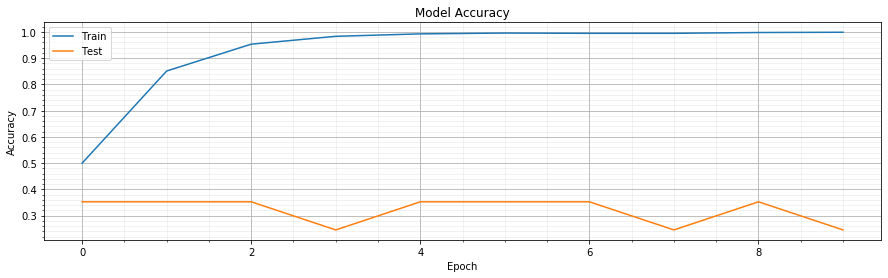

In [43]:
plot_validate(model_res_50, 'acc')

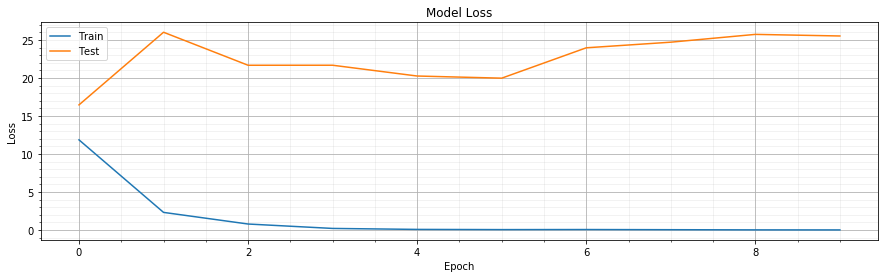

In [44]:
plot_validate(model_res_50, 'loss')

In [45]:
model_res_50.save('model_res_50_2020_05_13.model')
model_res_50.save_weights('model_res_50_2020_05_13.weights')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_res_50_2020_05_13.model/assets


In [47]:
model_res_50.evaluate_generator(train_generator_1000)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[26.87844568490982, 0.266]

## Stacked model

In [156]:
!pwd

/home/vincent/notebooks/Plants


In [158]:
!ls

Plants_pathology.ipynb
Plants_pathology_prepare_data_2020_05_03.ipynb
Plants_pathology_train_data_2020_05_03.ipynb
Plants_pathology_train_data_2020_05_13.ipynb
Untitled.ipynb
checkpoint
model_eff_B0_2020_05_14_total.model
model_eff_B0_2020_05_14_total.weights.data-00000-of-00001
model_eff_B0_2020_05_14_total.weights.index
model_eff_B0_2020_05_15.model
model_eff_B0_2020_05_15.weights.data-00000-of-00001
model_eff_B0_2020_05_15.weights.index
model_eff_B0_2020_05_16.model
model_eff_B0_2020_05_16.weights.data-00000-of-00001
model_eff_B0_2020_05_16.weights.index
model_eff_B0_base_2020_05_15.model
model_eff_B0_base_2020_05_15.weights.data-00000-of-00001
model_eff_B0_base_2020_05_15.weights.index
model_eff_B0_base_augmented_2020_05_15.model
model_eff_B0_base_augmented_2020_05_15.weights.data-00000-of-00001
model_eff_B0_base_augmented_2020_05_15.weights.index
plant_best.h5
plant_last.h5


In [183]:
path_csv = '/mnt/d/Google Drive/Compétition Plant Pathology/final_submission_2020_05_17.csv'

In [184]:
submission = pd.read_csv(path_csv)

In [185]:
submission.columns


Index(['Unnamed: 0', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [186]:
submission.columns = ['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']

In [189]:
submission['image_id'] = submission['image_id'].apply(lambda x: 'Test_' + str(x))

In [197]:
?submission.to_csv

In [198]:
submission.to_csv('/mnt/d/Google Drive/Compétition Plant Pathology/final_submission_2020_05_17_final.csv', index=False)

In [199]:
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000050,0.000100,0.999830,0.000020
1,Test_1,0.000051,0.000114,0.999812,0.000023
2,Test_2,0.000061,0.001814,0.000057,0.998068
3,Test_3,0.999575,0.000057,0.000187,0.000181
4,Test_4,0.000047,0.000423,0.999518,0.000012
...,...,...,...,...,...
1816,Test_1816,0.000044,0.000451,0.999492,0.000012
1817,Test_1817,0.000811,0.024015,0.000755,0.974419
1818,Test_1818,0.000048,0.000034,0.999887,0.000031
1819,Test_1819,0.999642,0.000064,0.000156,0.000137
